In [1]:
# from time import sleep
# sleep(4000)

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
import stable_baselines3.common.logger as logger

from tqdm import tqdm, trange

import flygym.util.vision as vision
from flygym.envs.nmf_mujoco import MuJoCoParameters

import numpy as np
import gymnasium as gym
from typing import Tuple
from dm_control import mjcf
from dm_control.rl.control import PhysicsError

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import MuJoCoParameters

from cpg_controller import NMFCPG

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [3]:
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_mode : string
        Type of movement performed by the floating object.
        Can be "random" (default value), "straightHeading", "circling" or "s_shape".
    move_speed : float
        Speed of the moving object. Angular velocity if move_mode=="circling" or "s_shape".
    """

    def __init__(
        self,
        size: Tuple[float, float] = (200, 200),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 2,
        obj_spawn_pos: Tuple[float, float, float] = (0, 2, 0),
        move_mode: str = "random",
        move_speed: float = 25,
    ):
        self.root_element = mjcf.RootElement()
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(10, 10),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")
        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=obj_spawn_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )
        self.friction = friction
        self.init_ball_pos = (obj_spawn_pos[0], obj_spawn_pos[1], obj_radius)
        self.ball_pos = self.init_ball_pos
        self.move_mode = move_mode
        self.move_speed = move_speed
        if move_mode == "straightHeading":
            self.direction = 0.5 * np.pi * (np.random.rand() - 0.5)
        elif move_mode == "circling":
            self.rotation_direction = np.random.choice([-1, 1])
            self.rotation_center = (
                np.random.randint(0, 4),
                self.rotation_direction * np.random.randint(6, 12),
            )  # (10*np.random.rand(),10*np.random.rand())
            self.radius = np.linalg.norm(
                np.array(self.ball_pos[0:2]) - np.array(self.rotation_center)
            )
            self.theta = np.arcsin(
                (self.ball_pos[1] - self.rotation_center[1]) / self.radius
            )
            self.move_speed = move_speed / self.radius
        elif move_mode == "s_shape":
            self.pos_func = lambda t: np.array(
                [
                    move_speed * t + obj_spawn_pos[0],
                    0.15 * move_speed * np.sin(t * 3) + obj_spawn_pos[1],
                    obj_radius,
                ]
            )
        elif move_mode != "random":
            raise NotImplementedError

        if move_speed == -1:
            base_speed = 0.003
            if self.move_mode == "straightHeading":
                self.move_speed = base_speed
            elif self.move_mode == "circling" or self.move_mode == "s_shape":
                self.move_speed = base_speed / self.radius
        else:
            self.move_speed = move_speed

        self.root_element.worldbody.add(
            "camera",
            name="birdseye_cam",
            mode="fixed",
            pos=(0, 0, 50),
            euler=(0, 0, 0),
            fovy=40,
        )

        self.curr_time = 0
        self._obj_pos_history_li = [[self.curr_time, *self.ball_pos]]

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def step(self, dt, physics):
        if self.move_mode == "random":
            x_disp = self.move_speed * (np.random.rand() - 0.45) * dt
            y_disp = self.move_speed * (np.random.rand() - 0.5) * dt
            self.ball_pos = self.ball_pos + np.array([x_disp, y_disp, 0])
        elif self.move_mode == "straightHeading":
            x_disp = self.move_speed * np.cos(self.direction) * dt
            y_disp = self.move_speed * np.sin(self.direction) * dt
            self.ball_pos = self.ball_pos + np.array([x_disp, y_disp, 0])
        elif self.move_mode == "circling":
            self.theta = self.theta + self.rotation_direction * self.move_speed * dt
            self.theta %= 2 * np.pi
            x = self.rotation_center[0] + self.radius * np.cos(self.theta)
            y = self.rotation_center[1] + self.radius * np.sin(self.theta)
            self.ball_pos = np.array([x, y, self.ball_pos[2]])
        elif self.move_mode == "s_shape":
            self.ball_pos = self.pos_func(self.curr_time)

        physics.bind(self.object_body).mocap_pos = self.ball_pos

        self.curr_time += dt
        self._obj_pos_history_li.append([self.curr_time, *self.ball_pos])

    def reset(self, physics):
        self.curr_time = 0
        self.ball_pos = self.init_ball_pos
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self._obj_pos_history_li = [[self.curr_time, *self.ball_pos]]

    @property
    def obj_pos_history(self):
        return np.array(self._obj_pos_history_li)


class NMFVisualTaxis(NMFCPG):
    def __init__(
        self,
        decision_dt=0.05,
        n_stabilisation_steps: int = 5000,
        obj_threshold=50,
        max_time=2,
        **kwargs
    ) -> None:
        if "sim_params" in kwargs:
            sim_params = kwargs["sim_params"]
            del kwargs["sim_params"]
        else:
            sim_params = MuJoCoParameters()
        sim_params.enable_vision = True
        sim_params.vision_refresh_rate = int(1 / decision_dt)
        self.max_time = max_time

        super().__init__(
            sim_params=sim_params,
            n_oscillators=6,
            n_stabilisation_steps=n_stabilisation_steps,
            **kwargs
        )
        self.decision_dt = decision_dt
        self.obj_threshold = obj_threshold
        self.num_substeps = int(decision_dt / self.timestep)

        # Override spaces
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6,))

        # Compute x-y position of each ommatidium
        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )

    def step(self, amplitude):
        try:
            for i in range(self.num_substeps):
                raw_obs, _, raw_term, raw_trunc, info = super().step(amplitude)
                super().render()
        except PhysicsError:
            print("Physics error, resetting environment")
            return np.zeros((6,), dtype="float32"), 0, False, True, {}

        assert abs(self.curr_time - self._last_vision_update_time) < 0.5 * self.timestep
        obs = self._get_visual_features().astype("float32")

        # calculate reward
        fly_pos = super().get_observation()["fly"][0, :2]
        obj_pos = self.arena.ball_pos[:2]
        tgt_pos = obj_pos - np.array([5, 0])
        fly_obj_dist = np.linalg.norm(fly_pos - obj_pos)
        fly_tgt_dist = np.linalg.norm(fly_pos - tgt_pos)
        unadjusted_reward = self._last_fly_tgt_dist - fly_tgt_dist
        if obs[2] + obs[5] < 0.005:  # lost object from both eyes, fail
            reward = -15
            terminated = True
            info["state_desc"] = "object lost visually"
        elif fly_tgt_dist > 15:  # too far from object, fail
            reward = -15
            terminated = True
            info["state_desc"] = "too far from object"
        elif fly_obj_dist < 3:  # too close/collision, fail
            reward = -5
            terminated = True
            info["state_desc"] = "collision with object"
        elif fly_tgt_dist < 1:  # ideal range
            reward = 3
            terminated = False
            info["state_desc"] = "ideal range"
        else:
            reward = unadjusted_reward
            terminated = False
            info["state_desc"] = "seeking"
        info["unadjusted_reward"] = unadjusted_reward
        info["fly_obj_dist"] = fly_obj_dist
        info["fly_tgt_dist"] = fly_tgt_dist
        truncated = self.curr_time > 1 and not terminated  # start a new episode
        self._last_fly_tgt_dist = fly_tgt_dist

        return obs, reward, terminated, truncated, info

    def reset(self):
        super().reset()
        self.arena.reset(self.physics)
        obs = self._get_visual_features().astype("float32")
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )
        return obs, {}

    def _get_visual_features(self):
        raw_obs = super().get_observation()
        # features = np.full((2, 3), np.nan)  # ({L, R}, {y_center, x_center, area})
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj[
                np.arange(is_obj.size) % 2 == 1
            ] = False  # only use pale-type ommatidia
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= config.raw_img_height_px  # normalize y_center
        features[:, 1] /= config.raw_img_width_px  # normalize x_center
        # features[:, :2] = features[:, :2] * 2 - 1  # center around 0
        features[:, 2] /= config.num_ommatidia_per_eye  # normalize area
        return features.flatten()

    def _calc_delta_dist(self, fly_pos, obj_pos):
        dist_from_obj = np.linalg.norm(fly_pos - obj_pos)
        if self._last_offset_from_ideal is not None:
            delta_dist = self._last_offset_from_ideal - dist_from_obj
        else:
            delta_dist = 0
        self._last_offset_from_ideal = dist_from_obj
        return delta_dist

In [4]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [5]:
arena = MovingObjArena(obj_spawn_pos=(5, 3, 0), move_mode="s_shape", move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
sim = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)


In [6]:
obs, info = sim.reset()

for i in range(10):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    print(reward, terminated, truncated, info)

sim.reset()

obs_hist = [obs]
visual_hist = [sim.curr_visual_input]
ball_pos_hist = []
for i in range(30):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    obs_hist.append(obs)
    ball_pos_hist.append(sim.arena.ball_pos[:2])
    if i < 9:
        visual_hist.append(sim.curr_visual_input)
    print(reward, terminated, truncated, info)

sim.save_video("visual_taxis_test3.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


-0.7625069781834366 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.7625069781834366, 'fly_obj_dist': 6.546089352098576, 'fly_tgt_dist': 3.7625069781834366}
-0.7044072507690018 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.7044072507690018, 'fly_obj_dist': 6.731368246125224, 'fly_tgt_dist': 4.466914228952438}
-0.6809652231709356 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.6809652231709356, 'fly_obj_dist': 7.030630249211843, 'fly_tgt_dist': 5.147879452123374}
-0.6073299045032723 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.6073299045032723, 'fly_obj_dist': 7.335415676927511, 'fly_tgt_dist': 5.755209356626646}
-0.5888139387035594 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.5888139387035594, 'fly_obj_dist': 7.6567708951508715, 'fly_tgt_dist': 6.344023295330206}
-0.4611460898526287 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.4611460898526287, 'fly_obj_dist': 7.932488646855834, 'fly_tgt_dist

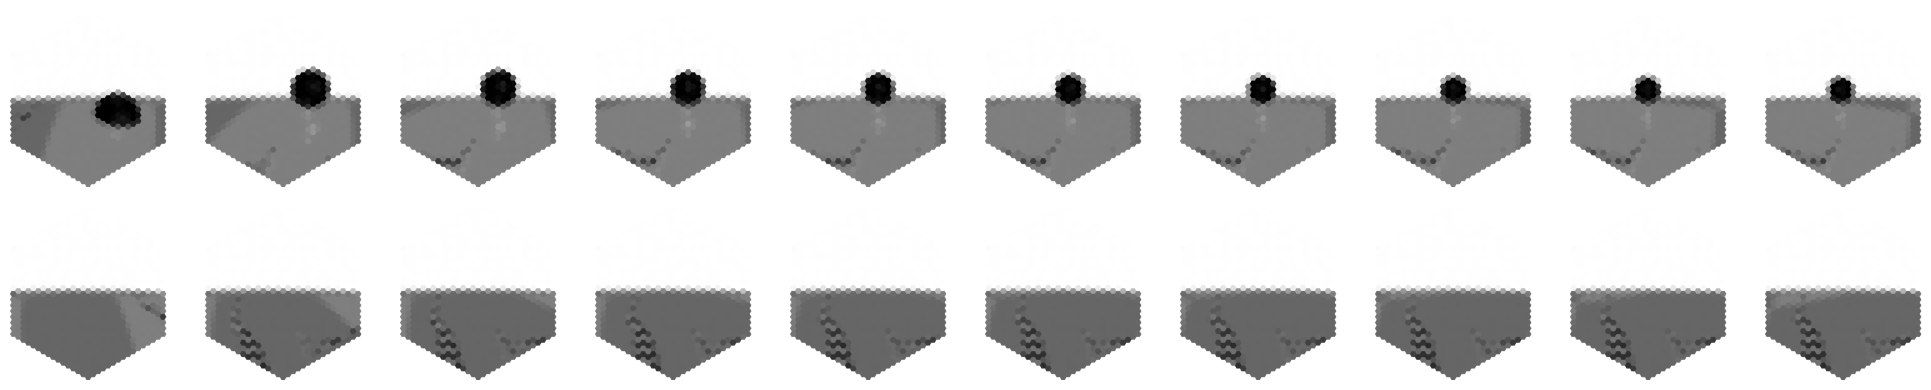

In [7]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4), tight_layout=True)
for i, visual_obs in enumerate(visual_hist):
    human_readable_img_left = vision.hex_pxls_to_human_readable(visual_obs[0], vision.ommatidia_id_map)
    axs[0, i].imshow(human_readable_img_left, cmap="gray", vmin=0, vmax=255)
    axs[0, i].axis("off")
    human_readable_img_right = vision.hex_pxls_to_human_readable(visual_obs[1], vision.ommatidia_id_map)
    axs[1, i].imshow(human_readable_img_right, cmap="gray", vmin=0, vmax=255)
    axs[1, i].axis("off")

(-0.01, 0.3)

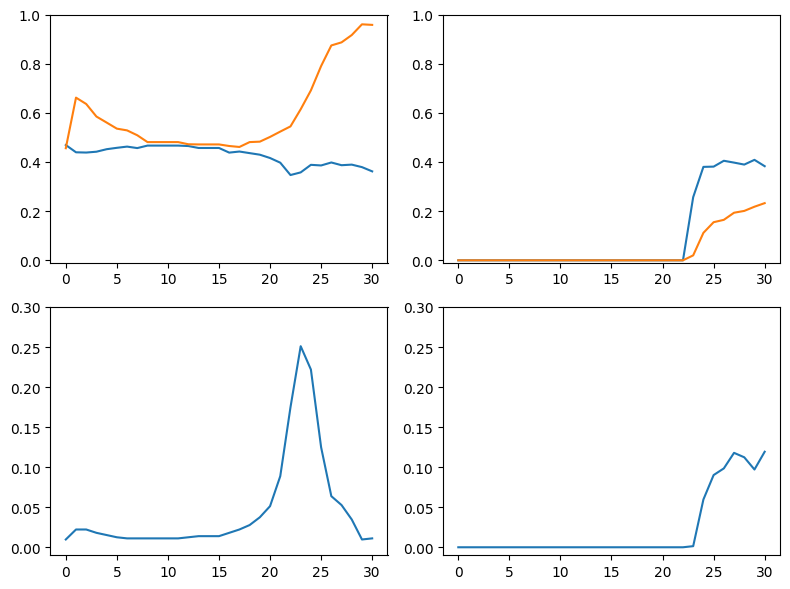

In [8]:
obs_hist = np.array(obs_hist)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 0].set_ylim(-0.01, 1)
axs[1, 0].plot(obs_hist[:, 2])
axs[1, 0].set_ylim(-0.01, 0.3)

axs[0, 1].plot(obs_hist[:, 3])
axs[0, 1].plot(obs_hist[:, 4])
axs[0, 1].set_ylim(-0.01, 1)
axs[1, 1].plot(obs_hist[:, 5])
axs[1, 1].set_ylim(-0.01, 0.3)

In [9]:
arena = MovingObjArena(obj_spawn_pos=(5, 3, 0), move_mode="s_shape", move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)
check_env(task)

In [10]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

log_dir = "logs/object_tracking_sac3"
checkpoint_callback = CheckpointCallback(
  save_freq=1000,
  save_path=log_dir,
  name_prefix="object_tracking_sac3",
  save_replay_buffer=True,
  save_vecnormalize=True,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
model.set_logger(my_logger)

model.learn(total_timesteps=30_000, progress_bar=True, callback=checkpoint_callback)

model.save("models/object_tracking_sac3")

Logging to logs/object_tracking_sac3
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -17.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 46       |
|    total_timesteps | 51       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.8     |
|    ep_rew_mean     | -18.9    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 80       |
|    total_timesteps | 86       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | -17.5    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1        |
|    time_elapsed    | 134      |
|    total_timesteps | 141      |
| train/             |          |
|    actor_loss      | -0.0336  |
|    critic_loss     | 14.3     |
|    ent_coef        | 0.679    |
|    ent_coef_loss   | -0.923   |
|    learning_rate   | 0.01     |
|    n_updates       | 40       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1        |
|    time_elapsed    | 206      |
|    total_timesteps | 219      |
| train/             |          |
|    actor_loss      | 0.136    |
|    critic_loss     | 5.99     |
|    ent_coef        | 0.344    |
|    ent_coef_loss   | -2.46    |
|    learning_rate   | 0.01     |
|    n_updates       | 118      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1        |
|    time_elapsed    | 285      |
|    total_timesteps | 303      |
| train/             |          |
|    actor_loss      | 0.369    |
|    critic_loss     | 4.63     |
|    ent_coef        | 0.179    |
|    ent_coef_loss   | -2.67    |
|    learning_rate   | 0.01     |
|    n_updates       | 202      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.1     |
|    ep_rew_mean     | -9.58    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1        |
|    time_elapsed    | 363      |
|    total_timesteps | 387      |
| train/             |          |
|    actor_loss      | 0.521    |
|    critic_loss     | 5.32     |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | -1.55    |
|    learning_rate   | 0.01     |
|    n_updates       | 286      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -8.15    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 1        |
|    time_elapsed    | 440      |
|    total_timesteps | 471      |
| train/             |          |
|    actor_loss      | 0.117    |
|    critic_loss     | 3.21     |
|    ent_coef        | 0.0723   |
|    ent_coef_loss   | -3.15    |
|    learning_rate   | 0.01     |
|    n_updates       | 370      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -7.15    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1        |
|    time_elapsed    | 517      |
|    total_timesteps | 555      |
| train/             |          |
|    actor_loss      | 0.378    |
|    critic_loss     | 2.9      |
|    ent_coef        | 0.0547   |
|    ent_coef_loss   | -1.87    |
|    learning_rate   | 0.01     |
|    n_updates       | 454      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.57    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 1        |
|    time_elapsed    | 593      |
|    total_timesteps | 639      |
| train/             |          |
|    actor_loss      | 0.406    |
|    critic_loss     | 1.9      |
|    ent_coef        | 0.0454   |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 0.01     |
|    n_updates       | 538      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | -6.05    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1        |
|    time_elapsed    | 671      |
|    total_timesteps | 723      |
| train/             |          |
|    actor_loss      | 0.27     |
|    critic_loss     | 1.36     |
|    ent_coef        | 0.0384   |
|    ent_coef_loss   | -2.13    |
|    learning_rate   | 0.01     |
|    n_updates       | 622      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | -5.71    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 1        |
|    time_elapsed    | 750      |
|    total_timesteps | 807      |
| train/             |          |
|    actor_loss      | 0.422    |
|    critic_loss     | 2.27     |
|    ent_coef        | 0.0319   |
|    ent_coef_loss   | -2.27    |
|    learning_rate   | 0.01     |
|    n_updates       | 706      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | -5.4     |
| time/              |          |
|    episodes        | 48       |
|    fps             | 1        |
|    time_elapsed    | 830      |
|    total_timesteps | 891      |
| train/             |          |
|    actor_loss      | 0.357    |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.0312   |
|    ent_coef_loss   | 0.345    |
|    learning_rate   | 0.01     |
|    n_updates       | 790      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | -5.12    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 1        |
|    time_elapsed    | 906      |
|    total_timesteps | 975      |
| train/             |          |
|    actor_loss      | 0.81     |
|    critic_loss     | 1.54     |
|    ent_coef        | 0.0338   |
|    ent_coef_loss   | 0.556    |
|    learning_rate   | 0.01     |
|    n_updates       | 874      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -4.79    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 1        |
|    time_elapsed    | 984      |
|    total_timesteps | 1059     |
| train/             |          |
|    actor_loss      | 0.868    |
|    critic_loss     | 0.635    |
|    ent_coef        | 0.0336   |
|    ent_coef_loss   | 0.174    |
|    learning_rate   | 0.01     |
|    n_updates       | 958      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -4.43    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 1        |
|    time_elapsed    | 1063     |
|    total_timesteps | 1143     |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 2.38     |
|    ent_coef        | 0.0302   |
|    ent_coef_loss   | 1.44     |
|    learning_rate   | 0.01     |
|    n_updates       | 1042     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -4.21    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 1        |
|    time_elapsed    | 1134     |
|    total_timesteps | 1221     |
| train/             |          |
|    actor_loss      | 0.952    |
|    critic_loss     | 2.57     |
|    ent_coef        | 0.0285   |
|    ent_coef_loss   | 1.46     |
|    learning_rate   | 0.01     |
|    n_updates       | 1120     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -4.3     |
| time/              |          |
|    episodes        | 68       |
|    fps             | 1        |
|    time_elapsed    | 1195     |
|    total_timesteps | 1288     |
| train/             |          |
|    actor_loss      | 1.26     |
|    critic_loss     | 2.31     |
|    ent_coef        | 0.0334   |
|    ent_coef_loss   | -0.729   |
|    learning_rate   | 0.01     |
|    n_updates       | 1187     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | -4.27    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 1        |
|    time_elapsed    | 1257     |
|    total_timesteps | 1357     |
| train/             |          |
|    actor_loss      | 1.19     |
|    critic_loss     | 1.44     |
|    ent_coef        | 0.0295   |
|    ent_coef_loss   | -1.66    |
|    learning_rate   | 0.01     |
|    n_updates       | 1256     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -4.05    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 1        |
|    time_elapsed    | 1333     |
|    total_timesteps | 1441     |
| train/             |          |
|    actor_loss      | 1.64     |
|    critic_loss     | 1.13     |
|    ent_coef        | 0.0255   |
|    ent_coef_loss   | 0.479    |
|    learning_rate   | 0.01     |
|    n_updates       | 1340     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | -3.73    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 1        |
|    time_elapsed    | 1410     |
|    total_timesteps | 1525     |
| train/             |          |
|    actor_loss      | 1.39     |
|    critic_loss     | 2.12     |
|    ent_coef        | 0.0241   |
|    ent_coef_loss   | -0.613   |
|    learning_rate   | 0.01     |
|    n_updates       | 1424     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -3.41    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 1        |
|    time_elapsed    | 1485     |
|    total_timesteps | 1609     |
| train/             |          |
|    actor_loss      | 1.91     |
|    critic_loss     | 2.06     |
|    ent_coef        | 0.025    |
|    ent_coef_loss   | 1.06     |
|    learning_rate   | 0.01     |
|    n_updates       | 1508     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -3.27    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 1        |
|    time_elapsed    | 1561     |
|    total_timesteps | 1693     |
| train/             |          |
|    actor_loss      | 1.99     |
|    critic_loss     | 1.24     |
|    ent_coef        | 0.0293   |
|    ent_coef_loss   | 1.58     |
|    learning_rate   | 0.01     |
|    n_updates       | 1592     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -3.11    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 1        |
|    time_elapsed    | 1636     |
|    total_timesteps | 1777     |
| train/             |          |
|    actor_loss      | 1.71     |
|    critic_loss     | 1.87     |
|    ent_coef        | 0.0365   |
|    ent_coef_loss   | 1.46     |
|    learning_rate   | 0.01     |
|    n_updates       | 1676     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -2.8     |
| time/              |          |
|    episodes        | 96       |
|    fps             | 1        |
|    time_elapsed    | 1710     |
|    total_timesteps | 1861     |
| train/             |          |
|    actor_loss      | 1.96     |
|    critic_loss     | 1.17     |
|    ent_coef        | 0.0337   |
|    ent_coef_loss   | 0.0768   |
|    learning_rate   | 0.01     |
|    n_updates       | 1760     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | -3.05    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 1        |
|    time_elapsed    | 1765     |
|    total_timesteps | 1924     |
| train/             |          |
|    actor_loss      | 1.52     |
|    critic_loss     | 0.661    |
|    ent_coef        | 0.0361   |
|    ent_coef_loss   | 0.21     |
|    learning_rate   | 0.01     |
|    n_updates       | 1823     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -2.19    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 1        |
|    time_elapsed    | 1839     |
|    total_timesteps | 2008     |
| train/             |          |
|    actor_loss      | 2.18     |
|    critic_loss     | 1.69     |
|    ent_coef        | 0.0327   |
|    ent_coef_loss   | -0.345   |
|    learning_rate   | 0.01     |
|    n_updates       | 1907     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -1.57    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 1        |
|    time_elapsed    | 1905     |
|    total_timesteps | 2086     |
| train/             |          |
|    actor_loss      | 1.85     |
|    critic_loss     | 2.61     |
|    ent_coef        | 0.0443   |
|    ent_coef_loss   | 0.199    |
|    learning_rate   | 0.01     |
|    n_updates       | 1985     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | -0.859   |
| time/              |          |
|    episodes        | 112      |
|    fps             | 1        |
|    time_elapsed    | 1977     |
|    total_timesteps | 2170     |
| train/             |          |
|    actor_loss      | 2.26     |
|    critic_loss     | 2.71     |
|    ent_coef        | 0.0457   |
|    ent_coef_loss   | 0.24     |
|    learning_rate   | 0.01     |
|    n_updates       | 2069     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | -0.717   |
| time/              |          |
|    episodes        | 116      |
|    fps             | 1        |
|    time_elapsed    | 2051     |
|    total_timesteps | 2254     |
| train/             |          |
|    actor_loss      | 2.39     |
|    critic_loss     | 0.833    |
|    ent_coef        | 0.0506   |
|    ent_coef_loss   | -0.488   |
|    learning_rate   | 0.01     |
|    n_updates       | 2153     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | -0.476   |
| time/              |          |
|    episodes        | 120      |
|    fps             | 1        |
|    time_elapsed    | 2124     |
|    total_timesteps | 2338     |
| train/             |          |
|    actor_loss      | 2.51     |
|    critic_loss     | 1.28     |
|    ent_coef        | 0.0482   |
|    ent_coef_loss   | -0.775   |
|    learning_rate   | 0.01     |
|    n_updates       | 2237     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | -0.18    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 1        |
|    time_elapsed    | 2197     |
|    total_timesteps | 2422     |
| train/             |          |
|    actor_loss      | 2.4      |
|    critic_loss     | 2.28     |
|    ent_coef        | 0.0386   |
|    ent_coef_loss   | -0.935   |
|    learning_rate   | 0.01     |
|    n_updates       | 2321     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 0.383    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 1        |
|    time_elapsed    | 2269     |
|    total_timesteps | 2506     |
| train/             |          |
|    actor_loss      | 2.43     |
|    critic_loss     | 1.3      |
|    ent_coef        | 0.0365   |
|    ent_coef_loss   | -0.399   |
|    learning_rate   | 0.01     |
|    n_updates       | 2405     |
---------------------------------


Physics error, resetting environment

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 0.62     |
| time/              |          |
|    episodes        | 132      |
|    fps             | 1        |
|    time_elapsed    | 2342     |
|    total_timesteps | 2590     |
| train/             |          |
|    actor_loss      | 2.22     |
|    critic_loss     | 1.92     |
|    ent_coef        | 0.0392   |
|    ent_coef_loss   | 0.877    |
|    learning_rate   | 0.01     |
|    n_updates       | 2489     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 1.03     |
| time/              |          |
|    episodes        | 136      |
|    fps             | 1        |
|    time_elapsed    | 2416     |
|    total_timesteps | 2674     |
| train/             |          |
|    actor_loss      | 2.37     |
|    critic_loss     | 2.38     |
|    ent_coef        | 0.0271   |
|    ent_coef_loss   | -0.563   |
|    learning_rate   | 0.01     |
|    n_updates       | 2573     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 1.16     |
| time/              |          |
|    episodes        | 140      |
|    fps             | 1        |
|    time_elapsed    | 2482     |
|    total_timesteps | 2750     |
| train/             |          |
|    actor_loss      | 2.43     |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.0315   |
|    ent_coef_loss   | 0.945    |
|    learning_rate   | 0.01     |
|    n_updates       | 2649     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 1.56     |
| time/              |          |
|    episodes        | 144      |
|    fps             | 1        |
|    time_elapsed    | 2554     |
|    total_timesteps | 2834     |
| train/             |          |
|    actor_loss      | 2.12     |
|    critic_loss     | 2.05     |
|    ent_coef        | 0.0325   |
|    ent_coef_loss   | -0.942   |
|    learning_rate   | 0.01     |
|    n_updates       | 2733     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 2.14     |
| time/              |          |
|    episodes        | 148      |
|    fps             | 1        |
|    time_elapsed    | 2626     |
|    total_timesteps | 2918     |
| train/             |          |
|    actor_loss      | 2.26     |
|    critic_loss     | 1.27     |
|    ent_coef        | 0.0291   |
|    ent_coef_loss   | 0.0217   |
|    learning_rate   | 0.01     |
|    n_updates       | 2817     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 2.63     |
| time/              |          |
|    episodes        | 152      |
|    fps             | 1        |
|    time_elapsed    | 2699     |
|    total_timesteps | 3002     |
| train/             |          |
|    actor_loss      | 2.07     |
|    critic_loss     | 0.77     |
|    ent_coef        | 0.0287   |
|    ent_coef_loss   | 0.318    |
|    learning_rate   | 0.01     |
|    n_updates       | 2901     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 3.03     |
| time/              |          |
|    episodes        | 156      |
|    fps             | 1        |
|    time_elapsed    | 2773     |
|    total_timesteps | 3086     |
| train/             |          |
|    actor_loss      | 2.18     |
|    critic_loss     | 1.21     |
|    ent_coef        | 0.0297   |
|    ent_coef_loss   | -1.03    |
|    learning_rate   | 0.01     |
|    n_updates       | 2985     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 3.48     |
| time/              |          |
|    episodes        | 160      |
|    fps             | 1        |
|    time_elapsed    | 2847     |
|    total_timesteps | 3170     |
| train/             |          |
|    actor_loss      | 2.39     |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.0264   |
|    ent_coef_loss   | 0.448    |
|    learning_rate   | 0.01     |
|    n_updates       | 3069     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 4.33     |
| time/              |          |
|    episodes        | 164      |
|    fps             | 1        |
|    time_elapsed    | 2924     |
|    total_timesteps | 3254     |
| train/             |          |
|    actor_loss      | 2.18     |
|    critic_loss     | 1.08     |
|    ent_coef        | 0.0328   |
|    ent_coef_loss   | 0.395    |
|    learning_rate   | 0.01     |
|    n_updates       | 3153     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 5.09     |
| time/              |          |
|    episodes        | 168      |
|    fps             | 1        |
|    time_elapsed    | 2993     |
|    total_timesteps | 3328     |
| train/             |          |
|    actor_loss      | 2.12     |
|    critic_loss     | 1.03     |
|    ent_coef        | 0.0421   |
|    ent_coef_loss   | 2.9      |
|    learning_rate   | 0.01     |
|    n_updates       | 3227     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 5.77     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 1        |
|    time_elapsed    | 3065     |
|    total_timesteps | 3406     |
| train/             |          |
|    actor_loss      | 2.02     |
|    critic_loss     | 1.99     |
|    ent_coef        | 0.042    |
|    ent_coef_loss   | -1.19    |
|    learning_rate   | 0.01     |
|    n_updates       | 3305     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 6.49     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 1        |
|    time_elapsed    | 3145     |
|    total_timesteps | 3490     |
| train/             |          |
|    actor_loss      | 1.75     |
|    critic_loss     | 2.1      |
|    ent_coef        | 0.0475   |
|    ent_coef_loss   | 0.28     |
|    learning_rate   | 0.01     |
|    n_updates       | 3389     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 7.3      |
| time/              |          |
|    episodes        | 180      |
|    fps             | 1        |
|    time_elapsed    | 3223     |
|    total_timesteps | 3574     |
| train/             |          |
|    actor_loss      | 2.04     |
|    critic_loss     | 1.9      |
|    ent_coef        | 0.045    |
|    ent_coef_loss   | -0.329   |
|    learning_rate   | 0.01     |
|    n_updates       | 3473     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 8.26     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 1        |
|    time_elapsed    | 3302     |
|    total_timesteps | 3658     |
| train/             |          |
|    actor_loss      | 2.05     |
|    critic_loss     | 1.38     |
|    ent_coef        | 0.0519   |
|    ent_coef_loss   | -0.0504  |
|    learning_rate   | 0.01     |
|    n_updates       | 3557     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 9.05     |
| time/              |          |
|    episodes        | 188      |
|    fps             | 1        |
|    time_elapsed    | 3380     |
|    total_timesteps | 3742     |
| train/             |          |
|    actor_loss      | 1.64     |
|    critic_loss     | 1.64     |
|    ent_coef        | 0.0681   |
|    ent_coef_loss   | 0.706    |
|    learning_rate   | 0.01     |
|    n_updates       | 3641     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 9.98     |
| time/              |          |
|    episodes        | 192      |
|    fps             | 1        |
|    time_elapsed    | 3457     |
|    total_timesteps | 3826     |
| train/             |          |
|    actor_loss      | 1.41     |
|    critic_loss     | 1.55     |
|    ent_coef        | 0.069    |
|    ent_coef_loss   | 0.883    |
|    learning_rate   | 0.01     |
|    n_updates       | 3725     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.5     |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    episodes        | 196      |
|    fps             | 1        |
|    time_elapsed    | 3535     |
|    total_timesteps | 3910     |
| train/             |          |
|    actor_loss      | 1.24     |
|    critic_loss     | 1        |
|    ent_coef        | 0.0734   |
|    ent_coef_loss   | 0.375    |
|    learning_rate   | 0.01     |
|    n_updates       | 3809     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 11.9     |
| time/              |          |
|    episodes        | 200      |
|    fps             | 1        |
|    time_elapsed    | 3611     |
|    total_timesteps | 3994     |
| train/             |          |
|    actor_loss      | 1.07     |
|    critic_loss     | 1.58     |
|    ent_coef        | 0.0675   |
|    ent_coef_loss   | 1.17     |
|    learning_rate   | 0.01     |
|    n_updates       | 3893     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 12.6     |
| time/              |          |
|    episodes        | 204      |
|    fps             | 1        |
|    time_elapsed    | 3690     |
|    total_timesteps | 4078     |
| train/             |          |
|    actor_loss      | 0.78     |
|    critic_loss     | 2.14     |
|    ent_coef        | 0.0671   |
|    ent_coef_loss   | -0.528   |
|    learning_rate   | 0.01     |
|    n_updates       | 3977     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 13.5     |
| time/              |          |
|    episodes        | 208      |
|    fps             | 1        |
|    time_elapsed    | 3766     |
|    total_timesteps | 4162     |
| train/             |          |
|    actor_loss      | 0.496    |
|    critic_loss     | 1.91     |
|    ent_coef        | 0.0601   |
|    ent_coef_loss   | 0.801    |
|    learning_rate   | 0.01     |
|    n_updates       | 4061     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 13.9     |
| time/              |          |
|    episodes        | 212      |
|    fps             | 1        |
|    time_elapsed    | 3842     |
|    total_timesteps | 4246     |
| train/             |          |
|    actor_loss      | 0.34     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.0662   |
|    ent_coef_loss   | -1.6     |
|    learning_rate   | 0.01     |
|    n_updates       | 4145     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    episodes        | 216      |
|    fps             | 1        |
|    time_elapsed    | 3920     |
|    total_timesteps | 4330     |
| train/             |          |
|    actor_loss      | 0.187    |
|    critic_loss     | 1.2      |
|    ent_coef        | 0.0588   |
|    ent_coef_loss   | 0.0783   |
|    learning_rate   | 0.01     |
|    n_updates       | 4229     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 220      |
|    fps             | 1        |
|    time_elapsed    | 3997     |
|    total_timesteps | 4414     |
| train/             |          |
|    actor_loss      | -0.573   |
|    critic_loss     | 1.62     |
|    ent_coef        | 0.0617   |
|    ent_coef_loss   | 0.368    |
|    learning_rate   | 0.01     |
|    n_updates       | 4313     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 14.9     |
| time/              |          |
|    episodes        | 224      |
|    fps             | 1        |
|    time_elapsed    | 4074     |
|    total_timesteps | 4498     |
| train/             |          |
|    actor_loss      | -0.142   |
|    critic_loss     | 1.71     |
|    ent_coef        | 0.0648   |
|    ent_coef_loss   | 0.147    |
|    learning_rate   | 0.01     |
|    n_updates       | 4397     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 15       |
| time/              |          |
|    episodes        | 228      |
|    fps             | 1        |
|    time_elapsed    | 4152     |
|    total_timesteps | 4582     |
| train/             |          |
|    actor_loss      | -0.0953  |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.0713   |
|    ent_coef_loss   | 0.292    |
|    learning_rate   | 0.01     |
|    n_updates       | 4481     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 15.4     |
| time/              |          |
|    episodes        | 232      |
|    fps             | 1        |
|    time_elapsed    | 4229     |
|    total_timesteps | 4666     |
| train/             |          |
|    actor_loss      | -0.138   |
|    critic_loss     | 1.89     |
|    ent_coef        | 0.0616   |
|    ent_coef_loss   | 0.964    |
|    learning_rate   | 0.01     |
|    n_updates       | 4565     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16       |
| time/              |          |
|    episodes        | 236      |
|    fps             | 1        |
|    time_elapsed    | 4306     |
|    total_timesteps | 4750     |
| train/             |          |
|    actor_loss      | -1.4     |
|    critic_loss     | 1.69     |
|    ent_coef        | 0.0663   |
|    ent_coef_loss   | 0.512    |
|    learning_rate   | 0.01     |
|    n_updates       | 4649     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.2     |
| time/              |          |
|    episodes        | 240      |
|    fps             | 1        |
|    time_elapsed    | 4379     |
|    total_timesteps | 4828     |
| train/             |          |
|    actor_loss      | -0.868   |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.0738   |
|    ent_coef_loss   | -0.337   |
|    learning_rate   | 0.01     |
|    n_updates       | 4727     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 16.4     |
| time/              |          |
|    episodes        | 244      |
|    fps             | 1        |
|    time_elapsed    | 4452     |
|    total_timesteps | 4907     |
| train/             |          |
|    actor_loss      | -1.58    |
|    critic_loss     | 3.11     |
|    ent_coef        | 0.0688   |
|    ent_coef_loss   | -0.0809  |
|    learning_rate   | 0.01     |
|    n_updates       | 4806     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 16.9     |
| time/              |          |
|    episodes        | 248      |
|    fps             | 1        |
|    time_elapsed    | 4529     |
|    total_timesteps | 4991     |
| train/             |          |
|    actor_loss      | -1.18    |
|    critic_loss     | 1.73     |
|    ent_coef        | 0.0802   |
|    ent_coef_loss   | -0.707   |
|    learning_rate   | 0.01     |
|    n_updates       | 4890     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 17.6     |
| time/              |          |
|    episodes        | 252      |
|    fps             | 1        |
|    time_elapsed    | 4605     |
|    total_timesteps | 5075     |
| train/             |          |
|    actor_loss      | -1.28    |
|    critic_loss     | 2.57     |
|    ent_coef        | 0.0765   |
|    ent_coef_loss   | -0.126   |
|    learning_rate   | 0.01     |
|    n_updates       | 4974     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 17.7     |
| time/              |          |
|    episodes        | 256      |
|    fps             | 1        |
|    time_elapsed    | 4682     |
|    total_timesteps | 5158     |
| train/             |          |
|    actor_loss      | -2.17    |
|    critic_loss     | 2.27     |
|    ent_coef        | 0.0766   |
|    ent_coef_loss   | -0.421   |
|    learning_rate   | 0.01     |
|    n_updates       | 5057     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 18       |
| time/              |          |
|    episodes        | 260      |
|    fps             | 1        |
|    time_elapsed    | 4759     |
|    total_timesteps | 5242     |
| train/             |          |
|    actor_loss      | -1.8     |
|    critic_loss     | 2.46     |
|    ent_coef        | 0.1      |
|    ent_coef_loss   | -0.0516  |
|    learning_rate   | 0.01     |
|    n_updates       | 5141     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 18.3     |
| time/              |          |
|    episodes        | 264      |
|    fps             | 1        |
|    time_elapsed    | 4835     |
|    total_timesteps | 5326     |
| train/             |          |
|    actor_loss      | -2.24    |
|    critic_loss     | 3.26     |
|    ent_coef        | 0.0878   |
|    ent_coef_loss   | 0.453    |
|    learning_rate   | 0.01     |
|    n_updates       | 5225     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 18.6     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 1        |
|    time_elapsed    | 4914     |
|    total_timesteps | 5410     |
| train/             |          |
|    actor_loss      | -2.56    |
|    critic_loss     | 3.31     |
|    ent_coef        | 0.109    |
|    ent_coef_loss   | 0.571    |
|    learning_rate   | 0.01     |
|    n_updates       | 5309     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 18.8     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 1        |
|    time_elapsed    | 4992     |
|    total_timesteps | 5494     |
| train/             |          |
|    actor_loss      | -2.33    |
|    critic_loss     | 2.55     |
|    ent_coef        | 0.112    |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 0.01     |
|    n_updates       | 5393     |
---------------------------------


Physics error, resetting environment

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 18.8     |
| time/              |          |
|    episodes        | 276      |
|    fps             | 1        |
|    time_elapsed    | 5067     |
|    total_timesteps | 5576     |
| train/             |          |
|    actor_loss      | -3.3     |
|    critic_loss     | 2.51     |
|    ent_coef        | 0.105    |
|    ent_coef_loss   | 0.272    |
|    learning_rate   | 0.01     |
|    n_updates       | 5475     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 18.2     |
| time/              |          |
|    episodes        | 280      |
|    fps             | 1        |
|    time_elapsed    | 5142     |
|    total_timesteps | 5657     |
| train/             |          |
|    actor_loss      | -2.96    |
|    critic_loss     | 2.25     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | -0.128   |
|    learning_rate   | 0.01     |
|    n_updates       | 5556     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 17.7     |
| time/              |          |
|    episodes        | 284      |
|    fps             | 1        |
|    time_elapsed    | 5220     |
|    total_timesteps | 5741     |
| train/             |          |
|    actor_loss      | -3.63    |
|    critic_loss     | 3.02     |
|    ent_coef        | 0.11     |
|    ent_coef_loss   | -0.626   |
|    learning_rate   | 0.01     |
|    n_updates       | 5640     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 17.3     |
| time/              |          |
|    episodes        | 288      |
|    fps             | 1        |
|    time_elapsed    | 5299     |
|    total_timesteps | 5825     |
| train/             |          |
|    actor_loss      | -3.1     |
|    critic_loss     | 3.49     |
|    ent_coef        | 0.131    |
|    ent_coef_loss   | -0.341   |
|    learning_rate   | 0.01     |
|    n_updates       | 5724     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 17.1     |
| time/              |          |
|    episodes        | 292      |
|    fps             | 1        |
|    time_elapsed    | 5376     |
|    total_timesteps | 5908     |
| train/             |          |
|    actor_loss      | -4       |
|    critic_loss     | 3.71     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | -0.993   |
|    learning_rate   | 0.01     |
|    n_updates       | 5807     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 16.5     |
| time/              |          |
|    episodes        | 296      |
|    fps             | 1        |
|    time_elapsed    | 5446     |
|    total_timesteps | 5984     |
| train/             |          |
|    actor_loss      | -4.16    |
|    critic_loss     | 3.5      |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | -0.0697  |
|    learning_rate   | 0.01     |
|    n_updates       | 5883     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 16.7     |
| time/              |          |
|    episodes        | 300      |
|    fps             | 1        |
|    time_elapsed    | 5519     |
|    total_timesteps | 6063     |
| train/             |          |
|    actor_loss      | -4.34    |
|    critic_loss     | 3.14     |
|    ent_coef        | 0.131    |
|    ent_coef_loss   | 0.287    |
|    learning_rate   | 0.01     |
|    n_updates       | 5962     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 16.7     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 1        |
|    time_elapsed    | 5595     |
|    total_timesteps | 6146     |
| train/             |          |
|    actor_loss      | -3.77    |
|    critic_loss     | 3.88     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | 0.474    |
|    learning_rate   | 0.01     |
|    n_updates       | 6045     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 17.1     |
| time/              |          |
|    episodes        | 308      |
|    fps             | 1        |
|    time_elapsed    | 5671     |
|    total_timesteps | 6230     |
| train/             |          |
|    actor_loss      | -4.15    |
|    critic_loss     | 2.77     |
|    ent_coef        | 0.109    |
|    ent_coef_loss   | 0.859    |
|    learning_rate   | 0.01     |
|    n_updates       | 6129     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 17.3     |
| time/              |          |
|    episodes        | 312      |
|    fps             | 1        |
|    time_elapsed    | 5748     |
|    total_timesteps | 6314     |
| train/             |          |
|    actor_loss      | -4.21    |
|    critic_loss     | 3.85     |
|    ent_coef        | 0.124    |
|    ent_coef_loss   | -0.116   |
|    learning_rate   | 0.01     |
|    n_updates       | 6213     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 17.8     |
| time/              |          |
|    episodes        | 316      |
|    fps             | 1        |
|    time_elapsed    | 5826     |
|    total_timesteps | 6398     |
| train/             |          |
|    actor_loss      | -4.81    |
|    critic_loss     | 4.03     |
|    ent_coef        | 0.137    |
|    ent_coef_loss   | -0.195   |
|    learning_rate   | 0.01     |
|    n_updates       | 6297     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 18.1     |
| time/              |          |
|    episodes        | 320      |
|    fps             | 1        |
|    time_elapsed    | 5904     |
|    total_timesteps | 6482     |
| train/             |          |
|    actor_loss      | -4.74    |
|    critic_loss     | 5.82     |
|    ent_coef        | 0.127    |
|    ent_coef_loss   | -0.151   |
|    learning_rate   | 0.01     |
|    n_updates       | 6381     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 18.2     |
| time/              |          |
|    episodes        | 324      |
|    fps             | 1        |
|    time_elapsed    | 5976     |
|    total_timesteps | 6560     |
| train/             |          |
|    actor_loss      | -4.55    |
|    critic_loss     | 4.51     |
|    ent_coef        | 0.141    |
|    ent_coef_loss   | 0.145    |
|    learning_rate   | 0.01     |
|    n_updates       | 6459     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 18.2     |
| time/              |          |
|    episodes        | 328      |
|    fps             | 1        |
|    time_elapsed    | 6052     |
|    total_timesteps | 6644     |
| train/             |          |
|    actor_loss      | -5.4     |
|    critic_loss     | 6.03     |
|    ent_coef        | 0.129    |
|    ent_coef_loss   | -0.242   |
|    learning_rate   | 0.01     |
|    n_updates       | 6543     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 18.7     |
| time/              |          |
|    episodes        | 332      |
|    fps             | 1        |
|    time_elapsed    | 6129     |
|    total_timesteps | 6728     |
| train/             |          |
|    actor_loss      | -5.02    |
|    critic_loss     | 4.34     |
|    ent_coef        | 0.142    |
|    ent_coef_loss   | -0.0444  |
|    learning_rate   | 0.01     |
|    n_updates       | 6627     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 18.7     |
| time/              |          |
|    episodes        | 336      |
|    fps             | 1        |
|    time_elapsed    | 6206     |
|    total_timesteps | 6812     |
| train/             |          |
|    actor_loss      | -5.62    |
|    critic_loss     | 5.34     |
|    ent_coef        | 0.137    |
|    ent_coef_loss   | 0.0719   |
|    learning_rate   | 0.01     |
|    n_updates       | 6711     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.5     |
| time/              |          |
|    episodes        | 340      |
|    fps             | 1        |
|    time_elapsed    | 6284     |
|    total_timesteps | 6896     |
| train/             |          |
|    actor_loss      | -5.69    |
|    critic_loss     | 5.9      |
|    ent_coef        | 0.135    |
|    ent_coef_loss   | -0.182   |
|    learning_rate   | 0.01     |
|    n_updates       | 6795     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.6     |
| time/              |          |
|    episodes        | 344      |
|    fps             | 1        |
|    time_elapsed    | 6360     |
|    total_timesteps | 6980     |
| train/             |          |
|    actor_loss      | -5.75    |
|    critic_loss     | 3.61     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | 0.196    |
|    learning_rate   | 0.01     |
|    n_updates       | 6879     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 348      |
|    fps             | 1        |
|    time_elapsed    | 6434     |
|    total_timesteps | 7060     |
| train/             |          |
|    actor_loss      | -6.14    |
|    critic_loss     | 5.27     |
|    ent_coef        | 0.153    |
|    ent_coef_loss   | 0.572    |
|    learning_rate   | 0.01     |
|    n_updates       | 6959     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19       |
| time/              |          |
|    episodes        | 352      |
|    fps             | 1        |
|    time_elapsed    | 6512     |
|    total_timesteps | 7144     |
| train/             |          |
|    actor_loss      | -5.52    |
|    critic_loss     | 7.48     |
|    ent_coef        | 0.161    |
|    ent_coef_loss   | 0.0312   |
|    learning_rate   | 0.01     |
|    n_updates       | 7043     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.3     |
| time/              |          |
|    episodes        | 356      |
|    fps             | 1        |
|    time_elapsed    | 6588     |
|    total_timesteps | 7228     |
| train/             |          |
|    actor_loss      | -7.28    |
|    critic_loss     | 6.59     |
|    ent_coef        | 0.159    |
|    ent_coef_loss   | 0.0911   |
|    learning_rate   | 0.01     |
|    n_updates       | 7127     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.3     |
| time/              |          |
|    episodes        | 360      |
|    fps             | 1        |
|    time_elapsed    | 6664     |
|    total_timesteps | 7312     |
| train/             |          |
|    actor_loss      | -5.8     |
|    critic_loss     | 7.58     |
|    ent_coef        | 0.173    |
|    ent_coef_loss   | -0.048   |
|    learning_rate   | 0.01     |
|    n_updates       | 7211     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 364      |
|    fps             | 1        |
|    time_elapsed    | 6739     |
|    total_timesteps | 7396     |
| train/             |          |
|    actor_loss      | -5.92    |
|    critic_loss     | 5.05     |
|    ent_coef        | 0.164    |
|    ent_coef_loss   | 0.177    |
|    learning_rate   | 0.01     |
|    n_updates       | 7295     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 368      |
|    fps             | 1        |
|    time_elapsed    | 6820     |
|    total_timesteps | 7480     |
| train/             |          |
|    actor_loss      | -6.39    |
|    critic_loss     | 10.5     |
|    ent_coef        | 0.152    |
|    ent_coef_loss   | 0.518    |
|    learning_rate   | 0.01     |
|    n_updates       | 7379     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19       |
| time/              |          |
|    episodes        | 372      |
|    fps             | 1        |
|    time_elapsed    | 6897     |
|    total_timesteps | 7563     |
| train/             |          |
|    actor_loss      | -6.58    |
|    critic_loss     | 8.73     |
|    ent_coef        | 0.179    |
|    ent_coef_loss   | -0.429   |
|    learning_rate   | 0.01     |
|    n_updates       | 7462     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 18.9     |
| time/              |          |
|    episodes        | 376      |
|    fps             | 1        |
|    time_elapsed    | 6973     |
|    total_timesteps | 7646     |
| train/             |          |
|    actor_loss      | -7.48    |
|    critic_loss     | 6.12     |
|    ent_coef        | 0.185    |
|    ent_coef_loss   | -0.518   |
|    learning_rate   | 0.01     |
|    n_updates       | 7545     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.2     |
| time/              |          |
|    episodes        | 380      |
|    fps             | 1        |
|    time_elapsed    | 7051     |
|    total_timesteps | 7730     |
| train/             |          |
|    actor_loss      | -6.53    |
|    critic_loss     | 6.12     |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | 0.0529   |
|    learning_rate   | 0.01     |
|    n_updates       | 7629     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 19.5     |
| time/              |          |
|    episodes        | 384      |
|    fps             | 1        |
|    time_elapsed    | 7130     |
|    total_timesteps | 7814     |
| train/             |          |
|    actor_loss      | -6.42    |
|    critic_loss     | 6.12     |
|    ent_coef        | 0.188    |
|    ent_coef_loss   | -0.143   |
|    learning_rate   | 0.01     |
|    n_updates       | 7713     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 20.1     |
| time/              |          |
|    episodes        | 388      |
|    fps             | 1        |
|    time_elapsed    | 7205     |
|    total_timesteps | 7896     |
| train/             |          |
|    actor_loss      | -5.78    |
|    critic_loss     | 9.25     |
|    ent_coef        | 0.175    |
|    ent_coef_loss   | 0.325    |
|    learning_rate   | 0.01     |
|    n_updates       | 7795     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 20.4     |
| time/              |          |
|    episodes        | 392      |
|    fps             | 1        |
|    time_elapsed    | 7283     |
|    total_timesteps | 7980     |
| train/             |          |
|    actor_loss      | -6.59    |
|    critic_loss     | 10.4     |
|    ent_coef        | 0.182    |
|    ent_coef_loss   | -0.313   |
|    learning_rate   | 0.01     |
|    n_updates       | 7879     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20.7     |
| time/              |          |
|    episodes        | 396      |
|    fps             | 1        |
|    time_elapsed    | 7360     |
|    total_timesteps | 8062     |
| train/             |          |
|    actor_loss      | -6.98    |
|    critic_loss     | 8.86     |
|    ent_coef        | 0.189    |
|    ent_coef_loss   | -0.164   |
|    learning_rate   | 0.01     |
|    n_updates       | 7961     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20.7     |
| time/              |          |
|    episodes        | 400      |
|    fps             | 1        |
|    time_elapsed    | 7443     |
|    total_timesteps | 8146     |
| train/             |          |
|    actor_loss      | -6.83    |
|    critic_loss     | 12.4     |
|    ent_coef        | 0.187    |
|    ent_coef_loss   | -0.259   |
|    learning_rate   | 0.01     |
|    n_updates       | 8045     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20.5     |
| time/              |          |
|    episodes        | 404      |
|    fps             | 1        |
|    time_elapsed    | 7527     |
|    total_timesteps | 8230     |
| train/             |          |
|    actor_loss      | -8.19    |
|    critic_loss     | 9.68     |
|    ent_coef        | 0.198    |
|    ent_coef_loss   | -0.0078  |
|    learning_rate   | 0.01     |
|    n_updates       | 8129     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20       |
| time/              |          |
|    episodes        | 408      |
|    fps             | 1        |
|    time_elapsed    | 7602     |
|    total_timesteps | 8308     |
| train/             |          |
|    actor_loss      | -7.19    |
|    critic_loss     | 7.96     |
|    ent_coef        | 0.194    |
|    ent_coef_loss   | -0.275   |
|    learning_rate   | 0.01     |
|    n_updates       | 8207     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 20.2     |
| time/              |          |
|    episodes        | 412      |
|    fps             | 1        |
|    time_elapsed    | 7682     |
|    total_timesteps | 8392     |
| train/             |          |
|    actor_loss      | -5.58    |
|    critic_loss     | 11.2     |
|    ent_coef        | 0.202    |
|    ent_coef_loss   | -0.272   |
|    learning_rate   | 0.01     |
|    n_updates       | 8291     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 19.7     |
| time/              |          |
|    episodes        | 416      |
|    fps             | 1        |
|    time_elapsed    | 7755     |
|    total_timesteps | 8473     |
| train/             |          |
|    actor_loss      | -7.27    |
|    critic_loss     | 7.23     |
|    ent_coef        | 0.194    |
|    ent_coef_loss   | -0.146   |
|    learning_rate   | 0.01     |
|    n_updates       | 8372     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 19.5     |
| time/              |          |
|    episodes        | 420      |
|    fps             | 1        |
|    time_elapsed    | 7836     |
|    total_timesteps | 8557     |
| train/             |          |
|    actor_loss      | -7.12    |
|    critic_loss     | 8.14     |
|    ent_coef        | 0.17     |
|    ent_coef_loss   | 0.316    |
|    learning_rate   | 0.01     |
|    n_updates       | 8456     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 19.6     |
| time/              |          |
|    episodes        | 424      |
|    fps             | 1        |
|    time_elapsed    | 7910     |
|    total_timesteps | 8641     |
| train/             |          |
|    actor_loss      | -6.86    |
|    critic_loss     | 11.2     |
|    ent_coef        | 0.194    |
|    ent_coef_loss   | 0.155    |
|    learning_rate   | 0.01     |
|    n_updates       | 8540     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 19.4     |
| time/              |          |
|    episodes        | 428      |
|    fps             | 1        |
|    time_elapsed    | 7988     |
|    total_timesteps | 8725     |
| train/             |          |
|    actor_loss      | -5.75    |
|    critic_loss     | 9.62     |
|    ent_coef        | 0.205    |
|    ent_coef_loss   | -0.294   |
|    learning_rate   | 0.01     |
|    n_updates       | 8624     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 18.9     |
| time/              |          |
|    episodes        | 432      |
|    fps             | 1        |
|    time_elapsed    | 8066     |
|    total_timesteps | 8809     |
| train/             |          |
|    actor_loss      | -8.78    |
|    critic_loss     | 7.97     |
|    ent_coef        | 0.168    |
|    ent_coef_loss   | 0.0935   |
|    learning_rate   | 0.01     |
|    n_updates       | 8708     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 18.7     |
| time/              |          |
|    episodes        | 436      |
|    fps             | 1        |
|    time_elapsed    | 8146     |
|    total_timesteps | 8893     |
| train/             |          |
|    actor_loss      | -7.33    |
|    critic_loss     | 11.5     |
|    ent_coef        | 0.182    |
|    ent_coef_loss   | -0.00697 |
|    learning_rate   | 0.01     |
|    n_updates       | 8792     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 18.5     |
| time/              |          |
|    episodes        | 440      |
|    fps             | 1        |
|    time_elapsed    | 8224     |
|    total_timesteps | 8977     |
| train/             |          |
|    actor_loss      | -6.48    |
|    critic_loss     | 7.24     |
|    ent_coef        | 0.186    |
|    ent_coef_loss   | -0.672   |
|    learning_rate   | 0.01     |
|    n_updates       | 8876     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 18.5     |
| time/              |          |
|    episodes        | 444      |
|    fps             | 1        |
|    time_elapsed    | 8303     |
|    total_timesteps | 9061     |
| train/             |          |
|    actor_loss      | -6.92    |
|    critic_loss     | 13.2     |
|    ent_coef        | 0.179    |
|    ent_coef_loss   | 0.277    |
|    learning_rate   | 0.01     |
|    n_updates       | 8960     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 18.6     |
| time/              |          |
|    episodes        | 448      |
|    fps             | 1        |
|    time_elapsed    | 8386     |
|    total_timesteps | 9145     |
| train/             |          |
|    actor_loss      | -4.63    |
|    critic_loss     | 13.7     |
|    ent_coef        | 0.178    |
|    ent_coef_loss   | 0.395    |
|    learning_rate   | 0.01     |
|    n_updates       | 9044     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 18       |
| time/              |          |
|    episodes        | 452      |
|    fps             | 1        |
|    time_elapsed    | 8469     |
|    total_timesteps | 9229     |
| train/             |          |
|    actor_loss      | -5.78    |
|    critic_loss     | 8.75     |
|    ent_coef        | 0.174    |
|    ent_coef_loss   | 0.221    |
|    learning_rate   | 0.01     |
|    n_updates       | 9128     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 17.5     |
| time/              |          |
|    episodes        | 456      |
|    fps             | 1        |
|    time_elapsed    | 8547     |
|    total_timesteps | 9308     |
| train/             |          |
|    actor_loss      | -7.27    |
|    critic_loss     | 14.1     |
|    ent_coef        | 0.192    |
|    ent_coef_loss   | -0.494   |
|    learning_rate   | 0.01     |
|    n_updates       | 9207     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 17.3     |
| time/              |          |
|    episodes        | 460      |
|    fps             | 1        |
|    time_elapsed    | 8628     |
|    total_timesteps | 9392     |
| train/             |          |
|    actor_loss      | -6.7     |
|    critic_loss     | 7.61     |
|    ent_coef        | 0.167    |
|    ent_coef_loss   | 0.158    |
|    learning_rate   | 0.01     |
|    n_updates       | 9291     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.9     |
| time/              |          |
|    episodes        | 464      |
|    fps             | 1        |
|    time_elapsed    | 8705     |
|    total_timesteps | 9476     |
| train/             |          |
|    actor_loss      | -7.39    |
|    critic_loss     | 10.6     |
|    ent_coef        | 0.164    |
|    ent_coef_loss   | -0.118   |
|    learning_rate   | 0.01     |
|    n_updates       | 9375     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.6     |
| time/              |          |
|    episodes        | 468      |
|    fps             | 1        |
|    time_elapsed    | 8781     |
|    total_timesteps | 9560     |
| train/             |          |
|    actor_loss      | -5.94    |
|    critic_loss     | 9.23     |
|    ent_coef        | 0.156    |
|    ent_coef_loss   | -0.0532  |
|    learning_rate   | 0.01     |
|    n_updates       | 9459     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.7     |
| time/              |          |
|    episodes        | 472      |
|    fps             | 1        |
|    time_elapsed    | 8857     |
|    total_timesteps | 9644     |
| train/             |          |
|    actor_loss      | -7.86    |
|    critic_loss     | 10.5     |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | -0.313   |
|    learning_rate   | 0.01     |
|    n_updates       | 9543     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.7     |
| time/              |          |
|    episodes        | 476      |
|    fps             | 1        |
|    time_elapsed    | 8934     |
|    total_timesteps | 9728     |
| train/             |          |
|    actor_loss      | -7.5     |
|    critic_loss     | 14       |
|    ent_coef        | 0.144    |
|    ent_coef_loss   | 0.686    |
|    learning_rate   | 0.01     |
|    n_updates       | 9627     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.7     |
| time/              |          |
|    episodes        | 480      |
|    fps             | 1        |
|    time_elapsed    | 9009     |
|    total_timesteps | 9812     |
| train/             |          |
|    actor_loss      | -7.6     |
|    critic_loss     | 8.55     |
|    ent_coef        | 0.162    |
|    ent_coef_loss   | -0.209   |
|    learning_rate   | 0.01     |
|    n_updates       | 9711     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 16.3     |
| time/              |          |
|    episodes        | 484      |
|    fps             | 1        |
|    time_elapsed    | 9091     |
|    total_timesteps | 9896     |
| train/             |          |
|    actor_loss      | -7.72    |
|    critic_loss     | 8.93     |
|    ent_coef        | 0.162    |
|    ent_coef_loss   | -0.515   |
|    learning_rate   | 0.01     |
|    n_updates       | 9795     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 15.6     |
| time/              |          |
|    episodes        | 488      |
|    fps             | 1        |
|    time_elapsed    | 9175     |
|    total_timesteps | 9980     |
| train/             |          |
|    actor_loss      | -6.77    |
|    critic_loss     | 11.8     |
|    ent_coef        | 0.182    |
|    ent_coef_loss   | 0.0407   |
|    learning_rate   | 0.01     |
|    n_updates       | 9879     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 14.7     |
| time/              |          |
|    episodes        | 492      |
|    fps             | 1        |
|    time_elapsed    | 9250     |
|    total_timesteps | 10061    |
| train/             |          |
|    actor_loss      | -5.96    |
|    critic_loss     | 14       |
|    ent_coef        | 0.174    |
|    ent_coef_loss   | 0.0661   |
|    learning_rate   | 0.01     |
|    n_updates       | 9960     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    episodes        | 496      |
|    fps             | 1        |
|    time_elapsed    | 9329     |
|    total_timesteps | 10145    |
| train/             |          |
|    actor_loss      | -6.8     |
|    critic_loss     | 9.38     |
|    ent_coef        | 0.155    |
|    ent_coef_loss   | 0.44     |
|    learning_rate   | 0.01     |
|    n_updates       | 10044    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 13.7     |
| time/              |          |
|    episodes        | 500      |
|    fps             | 1        |
|    time_elapsed    | 9408     |
|    total_timesteps | 10229    |
| train/             |          |
|    actor_loss      | -7.16    |
|    critic_loss     | 14.8     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | 0.227    |
|    learning_rate   | 0.01     |
|    n_updates       | 10128    |
---------------------------------


KeyboardInterrupt: 

In [11]:
obs, info = task.reset()
obs_hist = []
fly_pos_hist = []
ball_pos_hist = []
action_hist = []
reward_hist = []
visual_hist = []
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = task.step(action)
    fly_pos = task.get_observation()["fly"][0, :2]
    ball_pos = task.arena.ball_pos[:2]
    visual = task.curr_visual_input
    
    obs_hist.append(obs)
    action_hist.append(action)
    fly_pos_hist.append(fly_pos)
    ball_pos_hist.append(ball_pos)
    reward_hist.append(reward)
    visual_hist.append(visual)
    
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

obs_hist = np.array(obs_hist)
fly_pos_hist = np.array(fly_pos_hist)
ball_pos_hist = np.array(ball_pos_hist)
action_hist = np.array(action_hist)
reward_hist = np.array(reward_hist)
visual_hist = np.array(visual_hist)

task.save_video("outputs/visual_taxis_sac3.mp4")

Truncated